# Problema 1

In [1]:
from typing import List, Dict, Tuple, Optional
import itertools

# Define a slot: a time period in a room
class Slot:
    def __init__(self, day: int, period: str, room: str):
        self.day = day  # 1 or 2
        self.period = period  # 'M' or 'T'
        self.room = room  # 'Sala1', 'Sala2', 'Sala3'

    def __repr__(self):
        return f"Dia{self.day}-{self.period}-{self.room}"

    def time_id(self):
        """Returns a numeric time ID for comparison and ordering."""
        return (self.day - 1) * 2 + (0 if self.period == 'M' else 1)

# Represent a session variable
class Session:
    def __init__(self, name: str, domain: List[Slot]):
        self.name = name
        self.domain = domain
        self.assignment: Optional[Slot] = None

    def __repr__(self):
        return f"{self.name} -> {self.assignment}"

# CSP Solver
class CSP:
    def __init__(self, sessions: Dict[str, Session], constraints: List):
        self.sessions = sessions
        self.constraints = constraints

    def is_consistent(self, var: str, value: Slot, assignment: Dict[str, Slot]) -> bool:
        """Check if assigning value to var is consistent with all constraints."""
        temp_assignment = assignment.copy()
        temp_assignment[var] = value
        for constraint in self.constraints:
            if not constraint(temp_assignment):
                return False
        return True

    def backtrack(self, assignment: Dict[str, Slot]) -> Optional[Dict[str, Slot]]:
        if len(assignment) == len(self.sessions):
            return assignment

        # Choose unassigned session
        unassigned = [s for s in self.sessions.values() if s.name not in assignment]
        var = unassigned[0]

        for value in var.domain:
            if value not in assignment.values():
                if self.is_consistent(var.name, value, assignment):
                    assignment[var.name] = value
                    result = self.backtrack(assignment)
                    if result:
                        return result
                    del assignment[var.name]
        return None

In [2]:
# Generate all possible slots
def generate_slots():
    days = [1, 2]
    periods = ['M', 'T']  # Manhã, Tarde
    rooms = ['Sala1', 'Sala2', 'Sala3']
    return [Slot(d, p, r) for d, p, r in itertools.product(days, periods, rooms)]

# Helper: Get time_id of a session from assignment
def get_time(assignment: Dict[str, Slot], name: str) -> int:
    return assignment[name].time_id() if name in assignment else -1

# Constraint functions
def not_simultaneous(*sessions):
    def constraint(assignment):
        times = [get_time(assignment, s) for s in sessions if s in assignment]
        return len(times) == len(set(times))
    return constraint

def precedence(before, after):
    def constraint(assignment):
        if before in assignment and after in assignment:
            return get_time(assignment, before) < get_time(assignment, after)
        return True
    return constraint

def fixed_slot(session, target_slots):
    def constraint(assignment):
        if session in assignment:
            return assignment[session] in target_slots
        return True
    return constraint

def require_two_in(day, period):
    def constraint(assignment):
        count = sum(1 for slot in assignment.values() if slot.day == day and slot.period == period)
        return count <= 2  # Must be exactly 2 in the end
    return constraint

In [3]:
all_slots = generate_slots()
sessions = {name: Session(name, all_slots.copy()) for name in "ABCDEFGHIJK"}

constraints = []

# Conflict constraints (cannot be at same time)
for pair in ["AJ", "JI", "IE", "CF", "FG", "DH", "BD", "KE"]:
    constraints.append(not_simultaneous(*pair))

for group in ["BIHG", "AGE", "BHK", "ABCH", "DFJ"]:
    constraints.append(not_simultaneous(*group))

# Precedence constraints
constraints.append(precedence("E", "J"))
constraints.append(precedence("D", "K"))
constraints.append(precedence("F", "K"))

# Fixed slot: A at start, J at end
morning_day1 = [s for s in all_slots if s.day == 1 and s.period == 'M']
afternoon_day2 = [s for s in all_slots if s.day == 2 and s.period == 'T']
constraints.append(fixed_slot("A", morning_day1))
constraints.append(fixed_slot("J", afternoon_day2))

# Constraint: two sessions in the afternoon of day 2
constraints.append(require_two_in(day=2, period='T'))

csp =  CSP(sessions, constraints)

solution = csp.backtrack({})
if solution:
    for s in sorted(solution):
        print(f"Sessão {s}: {solution[s]}")
else:
    print("Nenhuma solução encontrada.")

Sessão A: Dia1-M-Sala1
Sessão B: Dia1-T-Sala1
Sessão C: Dia2-M-Sala1
Sessão D: Dia1-M-Sala2
Sessão E: Dia1-T-Sala2
Sessão F: Dia1-T-Sala3
Sessão G: Dia2-M-Sala2
Sessão H: Dia2-T-Sala1
Sessão I: Dia1-M-Sala3
Sessão J: Dia2-T-Sala2
Sessão K: Dia2-M-Sala3


# Problema 2

In [ ]:
%pip install matplotlib

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import List, Tuple, Dict, Optional

# ----------- Dados atualizados da Tabela Lawrence 10x5 -----------

jobs_data = {
    0: [(1, 72), (0, 87), (4, 95), (2, 66), (3, 60)],
    1: [(4, 5),  (3, 35), (0, 48), (2, 39), (1, 54)],
    2: [(1, 46), (3, 20), (2, 21), (0, 97), (4, 55)],
    3: [(0, 59), (3, 19), (4, 46), (1, 34), (2, 37)],
    4: [(4, 23), (2, 73), (3, 25), (1, 24), (0, 28)],
    5: [(3, 28), (0, 45), (4, 5),  (1, 78), (2, 83)],
    6: [(0, 53), (3, 71), (1, 37), (4, 29), (2, 12)],
    7: [(4, 12), (2, 87), (3, 33), (1, 55), (0, 38)],
    8: [(2, 49), (3, 83), (1, 40), (0, 48), (4, 7)],
    9: [(2, 65), (3, 17), (0, 90), (4, 27), (1, 23)],
}


In [ ]:
# ----------- Classes e Algoritmo -----------

class Task:
    def __init__(self, job_id: int, task_index: int, machine: int, duration: int):
        self.job_id = job_id
        self.task_index = task_index
        self.machine = machine
        self.duration = duration
        self.start_time: Optional[int] = None

    def __repr__(self):
        return f"Job {self.job_id}-T{self.task_index} (M{self.machine}, {self.duration}h)"

tasks: List[Task] = []
for job_id, job_tasks in jobs_data.items():
    for task_index, (machine, duration) in enumerate(job_tasks):
        tasks.append(Task(job_id, task_index, machine, duration))

def is_consistent(task: Task, start: int, schedule: Dict[int, List[Tuple[int, int]]], job_last_end: Dict[Tuple[int, int], int]) -> bool:
    for s, e in schedule[task.machine]:
        if not (start + task.duration <= s or start >= e):
            return False
    if task.task_index > 0:
        prev_end = job_last_end[(task.job_id, task.task_index - 1)]
        if start < prev_end:
            return False
    return True

def solve(tasks: List[Task]) -> List[Task]:
    schedule: Dict[int, List[Tuple[int, int]]] = {m: [] for m in range(5)}
    job_last_end: Dict[Tuple[int, int], int] = {}

    for task in sorted(tasks, key=lambda t: (t.job_id, t.task_index)):
        time = 0
        while True:
            if is_consistent(task, time, schedule, job_last_end):
                task.start_time = time
                schedule[task.machine].append((time, time + task.duration))
                job_last_end[(task.job_id, task.task_index)] = time + task.duration
                break
            time += 1
    return tasks

def plot_gantt(tasks: List[Task]):
    fig, ax = plt.subplots(figsize=(14, 6))
    colors = plt.cm.tab10.colors

    for task in tasks:
        y = task.machine
        x = task.start_time
        width = task.duration
        color = colors[task.job_id % len(colors)]
        ax.barh(y, width, left=x, color=color, edgecolor='black')
        ax.text(x + width / 2, y, f"J{task.job_id}T{task.task_index}", va='center', ha='center', fontsize=8, color='white')

    ax.set_yticks(range(5))
    ax.set_yticklabels([f"Máquina {i}" for i in range(5)])
    ax.set_xlabel("Tempo (horas)")
    ax.set_title("Escalonamento Job Shop - Lawrence 10x5")
    ax.grid(True)

    patches = [mpatches.Patch(color=colors[i % len(colors)], label=f"Job {i}") for i in range(10)]
    ax.legend(handles=patches, loc='upper right')
    plt.tight_layout()
    plt.show()


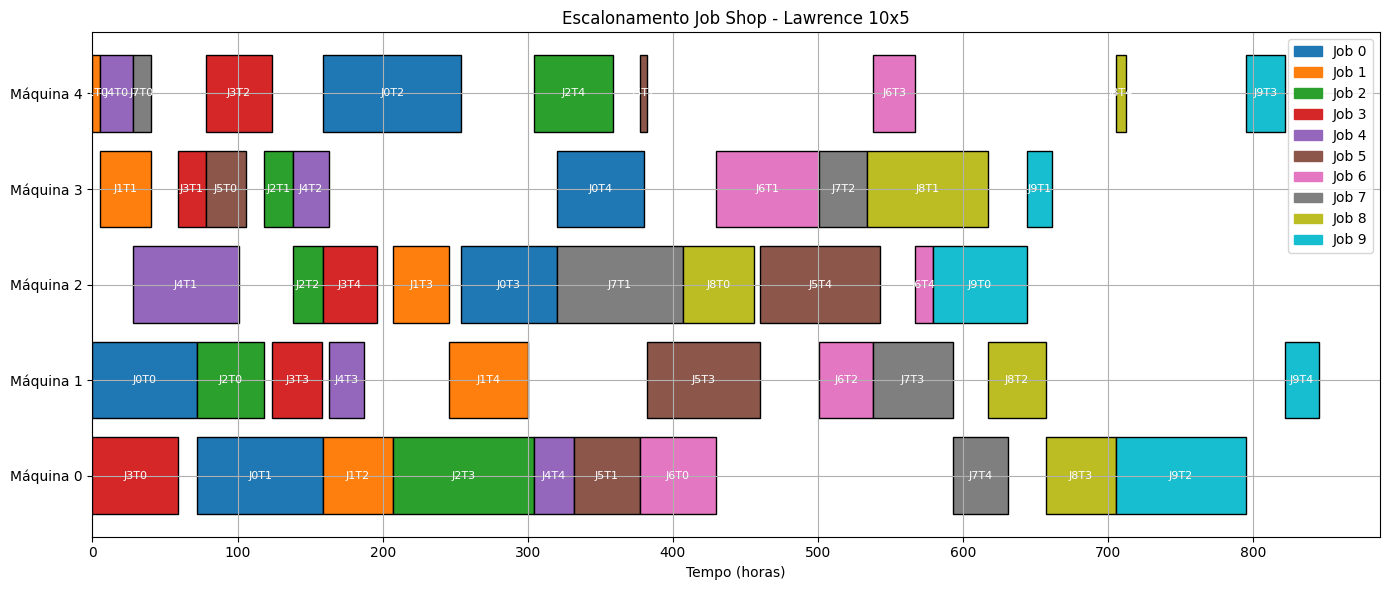

In [4]:
tasks = solve(tasks)
plot_gantt(tasks)